## Solving Semantle using locality-sensitive hashing (LSH)


### 1. Build index
 - Read all GLoVe vectors from a file.
 - Build an LSH index on the GLoVe vector space.


### 2. Set up a Semantle problem
 - Pick a random target word
 - Given a guess, compute the Euclidean distance from guess to target
 - Track guess history
 - Win when guess matches target (report number of guesses)
 
 
### 3. Search using index
 - Explore phase:
   - Randomly pick a word. Guess it.
   - If close to target, move to exploit phase with this word.
   - Otherwise, repeat.

 - Exploit phase:
   - Get vector for your best guess word.
   - Find neighbors. Guess those until you find a closer word. Don't guess a word you've already guessed.
   - When you find a closer word, repeat.

### 4. Test to find a good number for explore / exploit distance threshold
 - Repeatedly play Semantle with different thresholds
 - Find one that minimizes total number of guesses needed

In [170]:
import pickle
import random
import numpy as np

from annoy import AnnoyIndex
from tqdm.notebook import tqdm
from scipy.spatial.distance import euclidean, pdist, squareform
import scipy
import scipy.stats as stats

from matplotlib import pyplot as plt
from typing import *

## 1. Build index

In [22]:
def read_glove_file() -> Dict[str, List[float]]:
    """
    Yields the next 'size' vectors in a glove file.
    """
    glove_file = '/mnt/Spookley/datasets/glove/glove.6B.50d.txt'
    w_vecs = {}
    with tqdm(total=400000) as pbar:
        with open(glove_file) as fh:
            for line in fh.readlines():
                pbar.update(1)
                toks = line.strip().split()
                word = toks[0]
                # non-words like punctuation marks have entries, but we don't want those
                if not word.isalnum():  
                    continue
                # Some bigrams and trigrams are in the dataset. Skip those.
                try:
                    float(toks[1])
                except ValueError:
                    continue
                # No errors, parse the line.
                vec = [float(s) for s in toks[1:]]
                w_vecs[word] = vec
    return w_vecs

In [23]:
def build_index(w_vecs: Dict[str, List[float]]) -> Tuple[Dict[int, str], AnnoyIndex]:
    GLOVE_VEC_SIZE = 50
    idx_to_word = {}
    ann_index = AnnoyIndex(GLOVE_VEC_SIZE, 'euclidean')
    with tqdm(total=len(w_vecs)) as pbar:
        for i, w in enumerate(w_vecs.keys()):
            pbar.update(1)
            ann_index.add_item(i, w_vecs[w])
            idx_to_word[i] = w
    ann_index.build(20) # n trees
    return idx_to_word, ann_index

In [24]:
w_vecs = read_glove_file()

  0%|          | 0/400000 [00:00<?, ?it/s]

In [25]:
idx_to_word, ann_index = build_index(w_vecs)  # Takes about an hour and a GB of RAM.

  0%|          | 0/336158 [00:00<?, ?it/s]

In [26]:
ann_index.save('ann_index.idx')
import pickle
with open('idx_to_word.pkl', 'wb') as fh:
    pickle.dump(idx_to_word, fh)

In [27]:
v = w_vecs['wrath']
items = ann_index.get_nns_by_vector(v, 20)
for i in items:
    print(i, idx_to_word[i])

15070 wrath
11717 fury
14955 vengeance
17372 retribution
14709 desperation
22390 ridicule
20528 unleash
18415 ire
22103 dread
14898 betrayal
9242 provoked
7498 outrage
11292 lent
8089 shame
35067 vengeful
15739 pity
32726 merciless
22142 hysteria
11741 misery
22707 indignation


## 2. Set up a Semantle problem¶

In [28]:
class SemantleGame():
    def __init__(self, w_vecs):
        w_list = list(w_vecs.keys())
        self.target_word = random.choice(w_list[1000:50000])
        self.target_vec = w_vecs[self.target_word]
        
    def guess(self, word, vec) -> Tuple[bool, float]:
        # construct guess
        dist = euclidean(vec, self.target_vec)
        # check if win
        if word == self.target_word:
            return True, dist
        else:
            return False, dist
    
    def display_guesses(self):
        s = []
        for g in sorted(self.guesses, key = lambda g: g.dist):
            s.append(str(g))
        print('\n'.join(s))
        
    def __str__(self):
        return '\n'.join('{}: {}'.format(k, v) for k, v in self.__dict__.items())

## 2. Search using index

In [29]:
def dist_weighted_centroid(points, dists):
    # compute weighted centroid of the points. 
    # Close to target = higher weight.
    D = sum(dists)
    centroid = np.zeros((1, points.shape[1]))
    tot_weight = 0
    for i in range(len(points)):
        wi = D/max(dists[i], 0.00001)
        centroid += points[i]*wi
        tot_weight += wi
    return centroid / tot_weight

class SemantleSolver:
    
    def __init__(self, game: SemantleGame, n_random_guesses=10):
        self.game = game
        self.n_random_guesses = n_random_guesses
        self.closest_dist = float('inf')
        self.guesses = {}  # Dict[str: (float, int)] of {word: (dist, guess_num)}
        self.best_guess = None

    
    def guess(self, w_vecs, ann_index, idx_to_word) -> bool:
        # determine next guess
        g_type = 'random:'
        if len(self.guesses) < self.n_random_guesses:
            next_word = random.choice(list(w_vecs.keys()))
        
        if self.best_guess is not None and self.closest_dist <= self.dist_thresh:
            g_type = 'nearby:'
            # 'exploit' - guess words near our best candidate
            idxs_near_best = ann_index.get_nns_by_vector(v, 10000)
            for idx in idxs_near_best:
                w = idx_to_word[idx]
                if w not in self.guesses:
                    next_word = w
                    break
        else:
            next_word = random.choice(list(w_vecs.keys()))
        
        # guess the word
        win, dist = self.game.guess(next_word, w_vecs[next_word])
        self.guesses[next_word] = (dist, len(self.guesses)+1)

        # see if this one's better
        if self.best_guess is None or dist < self.closest_dist:
            print(g_type, next_word, "dist:", dist, "best:", 
                  self.best_guess, "best_dist:", self.closest_dist, "guesses:", len(self.guesses))
            self.closest_dist = dist
            self.best_guess = next_word
        
        if win:
            print("I win!", self.guesses)
            return True
        else:
            return False
        

In [30]:
game = SemantleGame(w_vecs)
player = SemantleSolver(game, n_random_guesses=10)

In [31]:
print(game.target_word)
won = False
while not won:
    won = player.guess(w_vecs, ann_index, idx_to_word)

awaken
random: stanway dist: 6.217341008843601 best: None best_dist: inf guesses: 1


AttributeError: 'SemantleSolver' object has no attribute 'dist_thresh'

In [ ]:
def dist_weighted_centroid(points, dists):
    # compute weighted centroid of the points. 
    # Close to target = higher weight.
    D = sum(dists)
    centroid = np.zeros((1, points.shape[1]))
    tot_weight = 0
    for i in range(len(points)):
        wi = D/max(dists[i], 0.00001)
        centroid += points[i]*wi
        tot_weight += wi
    return centroid / tot_weight

In [ ]:
points = np.random.random((5, 2))
target = np.random.random((1, 2))
dists = [euclidean(target,pi) for pi in points]

centroid = dist_weighted_centroid(points, dists)
print(centroid)
plt.xlim(0, 1.0)
plt.ylim(0, 1.0)
plt.plot(points[:,0], points[:, 1], 'b.')
plt.plot(centroid[0][0], centroid[0][1], 'g.')
plt.plot(target[0][0], target[0][1], 'ro')

In [211]:
def test_aimbot(n_points, n_dims) -> float:
    # generate some random points
    points = np.random.random((n_points, n_dims))

    # we're going to try and find this target point
    target = np.random.random((1, n_dims))
    
    # find dist from each point to the target
    dists = [euclidean(target,pi) for pi in points]
    
    centroid = dist_weighted_centroid(points, dists)[0]
    
    centroid_dist = euclidean(centroid, target)
    
    # find vec from each point to the centroid
    for i in range(points.shape[0]):
        vec_pc = centroid - point
        vec_pc_mag = scipy.linalg.norm(p1c)
        if centroid_dist < dists[i]:
            
    
    # find vector from point i to point j for each (i, j) pair. 
    # Multiply each vector by (dist[i]-dist[j]).
    vecs = []
    target_points = []
    target_confidences = []
    for i in range(points.shape[0]):
        for j in range(i+1, points.shape[0]):
            p1p2 = (points[j]-points[i])
            p1p2mag = scipy.linalg.norm(p1p2)
            p1p2_unit = p1p2 / p1p2mag
            if dists[i] < dists[j]:
                mag = dists[i]
                target_point = points[i] - p1p2_unit*mag
                confidence = (dists[j]-dists[i]) / p1p2mag
            else:
                # j is closer to target
                # make a vector from j to a target that is dists[j] away
                mag = dists[j]
                target_point = points[j] + p1p2_unit*mag
                confidence = (dists[i]-dists[j]) / p1p2mag
            #print(points[i], points[j], target_point, confidence)
            target_points.append(target_point)
            target_confidences.append(confidence**2)
    
    target_centroid = dist_weighted_centroid(np.array(target_points), target_confidences)[0]
    #vec_weighted = sum(w_vecs)
    #vec_weighted = vec_weighted / tot_mag
    
    # our best guess is that the target is centroid + vec_weighted.
    # Return the error.
    #guess_point = centroid+vec_weighted\
    #print(sum(target_confidences)/len(target_confidences))
    target_weight = np.max(target_confidences)
    guess_point = centroid + target_weight*(target_centroid-centroid)
    return points, target, centroid, target_centroid, guess_point


array([ 0.60169211, -0.17692472])

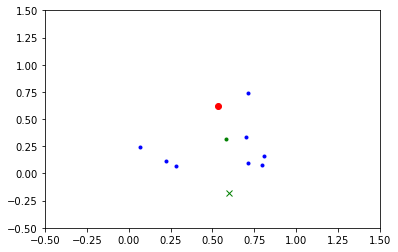

In [218]:
points, target, centroid, target_centroid, guess = test_aimbot(8, 2)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.plot(points[:,0], points[:, 1], 'b.')
plt.plot(centroid[0], centroid[1], 'g.')
plt.plot(target[0][0], target[0][1], 'ro')
plt.plot(guess[0], guess[1], 'gx')
guess

Text(0, 0.5, 'Error')

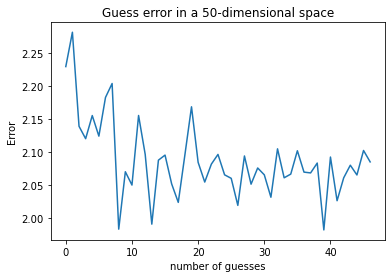

In [201]:

n_dims = 50
n_trials = 10
results = []
for n_points in range(3,50):
    result = 0
    for trial in range(n_trials):
        points, target, centroid, target_centroid, guess_point = test_aimbot(n_points, n_dims)
        result += euclidean(centroid, target)
    results.append(result / n_trials)
plt.plot(results)
plt.title('Guess error in a {}-dimensional space'.format(n_dims))
plt.xlabel('number of guesses')
plt.ylabel('Error')

In [17]:
v1 = np.array([1,1,1,1,1,1,])
v2 = np.array([1,0,0,1,1,1,])
v3 = np.array([1,0,3,1,0,3,])
v4 = np.array([5,2,3,1,2,3,])
v5 = np.array([4,0,3,3,4,9,])

vecs = np.array([v1, v2, v3, v4, v5])

target = np.array([5, 1.5, 5, 1.5, 5, 1.5])


In [ ]:
dists

In [ ]:
estimate = centroid + vec_weighted
print(target-centroid)

In [ ]:
np.random.random((1,10))